This is a general purpose image classifier that can be applied to datasets that have the data organized as shown below. To use this code select Run all. The code will prompt the user to provide the required input data. It will take only a minute or so to enter the data and your model will be up and training. I have used this code on numerous data sets with excellent results. The model will initially run for 10 epochs. After 10 epochs you are prompted to enter H to halt training or you can enter an integer that specifies how many more epochs to run. After those epochs complete you will be again prompted to continue or halt training. The code shows the % decreasee  of the validation loss at the end of each epoch. This is a good guide to use to decide to continue or halt training. As you near the bottom of the loss function the % decrease in loss becomes smaller. I typically halt training when the % decrease falls below 5%. However sometimes it is best to continue training until the loss increases. The code then automatically lowers the learning rate. This often enables the model to again start decreasing the loss. Your saved model is always returned with the weights set to those for the epoch with the lowest loss.   

data directory  
* train directory    
  * class 0
     * image 0
     * image 1
     * ......
     * image m
  * class 1
     * image 0
     * image 1
     * ......
     * image n
  * ......
  * class m
     * image 0
     * image 1
     * ......
     * image r
* valid directory ( optional if there is no validation directory validation data is created by partition of train data)  
   * class 0
     * image 0
     * image 1
     * ......
     * image x
   * class 1
     * image 0
     * image 1
     * ......
     * image y
   * ......
   * class m
     * image 0
     * image 1
     * ......
     * image z
* test directory ( optional if there is no test directory test data is created by partition of train data)  
   * class 0
     * image 0
     * image 1
     * ......
     * image a
   * class 1
     * image 0
     * image 1
     * ......
     * image b
   * ......
   * class m
     * image 0
     * image 1
     * ......
     * image c

## [1. Import Needed Modules](#import) ##
## [2 Define a function to print text in color](#pc) ##
## [3. Define a function to plot the number of images in dataset classes](#pcounts) ##
## [4 Define a function to return information on the dataset](#check) ##
## [5. Read in images and create a dataframe of image paths and class labels](#makedf) ##
## [6. Define a function that trims a dataset for the max number of class images](#trim) ##
## [7. Balance the trainning set using augmentation](#Balance) ##
## [8. Create train, test and validation generators](#gens) ##
## [9. Create a function to show Training Image Samples](#show) ##
## [10 Create a function to calculate the F1 score metric](#f1metric) ##
## [11. Create the Model](#model) ##
## [12. Create a custom Keras callback to continue or halt training](#callback) ##
## [13. Define a function to plot the training data](#plot) ##
## [14. Define a function save the training data to a csv file](#csv) ##
## [15. Define a function to make predictions on the test set](#predict) ##
## [16. Make predictions on test set, create Confusion Matrix and Classification Report](#result)
## [17. Define a function to save the trained model ](#save) ##
## [18 Define the run function which runs the classifier](#run) ##
## [19 Define the code to enable to initiate the run function](#cycle) ##
## [20. Evaluate Model Performance](#Conclusions) ##

### Recently Kaggle updated its docker file to load tensorflow 2.11.0. where before it loaded version 2.9.2 . However version 2.10.0 and above have a bug with respect to saving EfficientNet models. In my code if you select a medium or large model, the result is an EfficientNetB0 or B3 model is generated. So when you try to save the model you will receive a message saying the model can not be saved. If you want to save your model, uncomment the code line below which will install tensorflow version 2.9.2.

In [ ]:
#! pip install tensorflow==2.9.2

<a id="import"></a>
## <center>Import required modules</center>

In [ ]:
import pandas as pd
import numpy as np
from numpy import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import albumentations as A
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [ ]:
# Инициализирует генератор случайных чисел
def seed_everything(seed=42):
    # Инициализирует значение для TensorFlow
    tf.random.set_seed(seed)

    # Инициализирует значение для NumPy
    np.random.seed(seed)

    # Инициализирует значение для Python's
    random.seed(seed)

    # Заставляет TensorFlow использовать один поток
    # Несколько потоков являются потенциальным источником невоспроизводимых результатов.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Убедитесь, что TensorFlow использует детерминированную операцию везде, где это возможно
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

<a id="pc"></a>
## <center>Define a function to print text in specified rgb foreground and background colors</center>
### Add some PZAZZ to your printed output with this function  
form of the call is:  print_in_color(txt_msg, fore_tupple, back_tupple where:
* txt_msg is the string to be printed out  
* fore_tuple is tuple of the form (r,g,b) specifying the foreground color of the text
* back_tuple is tuple of the form (r,g,b) specifying the background color of the text

In [ ]:
def print_in_color(txt_msg,fore_tupple= (0,0,0) ,back_tupple=(255, 255, 255)):
    #печатает text_msg в цвете переднего плана, указанном four_tuple, с фоном, указанным back_tupple
    #text_msg - это текст, for_tuple - цветовой кортеж переднего плана (r,g, b), back_tupple - фоновый кортеж (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat))
    print('\33[0m', end='') # возвращает цвет печати по умолчанию обратно к черному

<a id="pcounts"></a>
## <center>Define a function that plots value counts for a column in a dataframe</center>

In [ ]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'family': 'serif', 'color': 'blue', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')
        plt.show()

<a id="check"></a>
# <center>Define a function to return information of the training data</center>
* train_dir is a string specifying the full path to the directory holding the training images
The function determines the total number of training images, the class with the most image files      
and their number and the class with the least image files and their number. This information is      
provided to the used to enable selection of various program parameters

In [ ]:
def check_dataset_size(train_dir):
    classes=sorted(os.listdir(train_dir))
    ftotal=0
    flargest=0
    fsmallest=100000000
    for klass in classes:
        classpath=os.path.join(train_dir,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            fcount=len(flist)
            if fcount>flargest:
                flargest=fcount
                maxclass=klass
            if fcount < fsmallest:
                fsmallest=fcount
                minclass=klass
            ftotal += fcount
    return ftotal, flargest, maxclass, fsmallest, minclass

<a id="makedf"></a>
# <center>Read in data and create train, test and validation data frames</center>


In [ ]:
def make_dataframes(train_dir,test_dir, val_dir, limiter, min_images):
    bad_images=[]
    skip_classes=[]
    # проверьте, какие каталоги существуют
    if test_dir == None and val_dir==None:
        dirlist=[train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist=[train_dir,  val_dir]
        names=['train', 'valid']
    elif val_dir == None:
        dirlist=[train_dir,  test_dir]
        names=['train', 'test']
    else:
        dirlist=[train_dir, test_dir, val_dir]
        names=['train','test', 'valid']
    ht=0 # установите начальное значение счетчика высоты
    wt=0  # установите начальное значение счетчика ширины
    total_good_files=0 # установите начальное значение счетчика общего количества хороших графических файлов
    zipdir=zip(names, dirlist)
    for name,d in zipdir: #перебирайте имена и каталоги
        filepaths=[] # инициализировать список путей к файлам
        labels=[] # инициализировать список меток классов
        classlist=sorted(os.listdir(d) )   # получите список всех классов в алфавитно-цифровом порядке
        for klass in classlist: # выполните итерацию по списку классов
            msg=f'processing images in {name} directory for class {klass}                                                  '
            print(msg, '\r', end='')
            good_file_count=0 # инициализируйте счетчик good_file для этого класса
            classpath=os.path.join(d, klass) # определите полный путь к классу
            if os.path.isdir(classpath): # убедитесь, что мы работаем с каталогом, а не с поддельным файлом
                flist=sorted(os.listdir(classpath)) # составьте список всех файлов для этого класса
                if name == 'train' and len(flist)< min_images:
                    skip_classes.append(klass)
                else:
                    if  klass not in skip_classes:
                        if limiter != None: # проверьте, было ли указано значение ограничителя, определяющее, сколько файлов следует использовать в любом классе
                            if limiter <len(flist): # если количество файлов превышает значение параметра limiter, то произвольная выборка ограниченного количества файлов
                                flist=np.random.choice(flist, limiter, replace=False)
                        for f in flist:
                            fpath=os.path.join(classpath,f) # создайте полный путь к файлу изображения
                            index=f.rfind('.')
                            ext=f[index+1:].lower() # the the file's extension
                            if ext not in ['jpg', 'jpeg', 'tiff', 'png', 'bmp'] :   # убедитесь, что расширение файла соответствует тому, которое работает с Keras
                                bad_images.append(fpath) # если расширение неподходящее, сохраните путь к файлу в списке плохих изображений
                            else:
                                try: # проверьте, не повреждены ли файлы изображений, если это так, не включайте их во фрейм данных
                                    img=cv2.imread(fpath)
                                    h=img.shape[0]
                                    w=img.shape[1]
                                    ht +=h # добавьте высоту и ширину изображений к счетчикам
                                    wt += w
                                    good_file_count +=1
                                    total_good_files +=1
                                    filepaths.append(fpath) # добавьте путь к файлу к списку допустимых путей к файлам
                                    labels.append(klass) # добавьте метку класса файла в список меток

                                except:
                                    bad_images.append(fpath) # если файл изображения неисправен, добавьте путь к файлу в список поврежденных изображений
        print('')
        Fseries=pd.Series(filepaths, name='filepaths') # создайте серию pandas для списков имен файлов и меток
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) # создайте фрейм данных со столбцами путями к файлам и метками
        # в зависимости от того, по какому каталогу мы выполняем итерацию, создаются фреймы данных
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            if test_dir == None and val_dir == None: # создайте train_df, test_df и valid_df из df
                pdf=df
                train_df, dummy_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
                valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
            elif test_dir == None: # создайте только train_df и test_drivef
                pdf=df
                train_df,test_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            elif val_dir == None:  # создайте train_df и valid_df
                pdf=df
                train_df,valid_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            else:
                train_df= df # тестовые и допустимые фреймы данных существуют, поэтому train_df - это просто df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    # вычислите среднюю высоту изображения и с помощью
    have=int(ht/total_good_files)
    wave=int(wt/total_good_files)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)
    if len(skip_classes)>0:
        msg=f'listed below are classes not included in the dataset because it had less than {min_images} training image files'
        print_in_color(msg)
        for klass in skip_classes:
            print (klass)

    counts=list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    if len(bad_images) == 0:
        print_in_color('All image files were properly processed and used in the dataframes')
    else:
        print_in_color(f'the are {len(bad_images)} bad image files and {total_good_files} proper image files in the dataset')
        for f in bad_images:
            print (f)
    plot_title='Images per Label in train set'
    plot_label_count (train_df,  plot_title)
    return train_df, test_df, valid_df, classes, class_count, max(counts), min(counts), have, wave

<a id="trim"></a>
## <center>Define a function that trims the classes in a dataframe</center>
* df is the dataframe
* max_samples is an integer specifies the maximum number of images a class can have
* min_samples is an integer specifying the minimum number of images a class must have to be included in the trimmed dataframe
* column is a string specifying the column name in the dataframe holding the class labels

In [ ]:
def trim(df, max_samples, min_samples, column):
    # столбец указывает, какой столбец фрейма данных следует использовать, обычно это столбец меток
    # df обычно является train_df
    df=df.copy()
    classes=df[column].unique() # получите классы в df
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)   # создает набор фреймов данных, содержащий только строки, имеющие метку класса
    trimmed_df = pd.DataFrame(columns = df.columns) # создайте пустой фрейм данных со столбцами, путями к файлам, метками
    for label in df[column].unique(): # выполните итерацию по каждой метке класса
        group=groups.get_group(label) # получите фрейм данных, связанный с меткой
        count=len(group) # определите, сколько файлов находится во фрейме данных
        if count > max_samples: # если во фрейме данных больше файлов, выполните выборку, чтобы в отобранных файлах было только n строк
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0) # добавьте отобранные файлы в фрейм данных trimmed_df
        else:
            if count>=min_samples: # если фрейм данных содержит больше минимального количества файлов, включите его в набор данных
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# верните это в случае, если некоторые классы имеют меньше min_samples
    class_count=len(classes) # верните это в случае, если некоторые классы имеют меньше, чем min_samples, и поэтому в них будет меньше классов
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count



<a id="balance"></a>
## <center>Expand train_df rows with augmented images so each class has n samples</center>
* df is the dataframe
* n is an integer specifying the number of images desired for each class
* column is a string specifying the column name of the dataframe that contains the class labels
* working_dir is a string specifying the path where augmented images will be stored
* img_size is a tupple (height,width) specifying the image size of the augmented images created

In [ ]:
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image): # при заданном изображении эта функция возвращает увеличенное изображение
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# каталог для хранения дополненных изображений
    if os.path.isdir(aug_dir):# начните с пустого каталога
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df[column].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # создайте каталоги классов в каталоге aug
    # создавайте и сохраняйте дополненные изображения
    total=0
    groups=df.groupby(column) # группировать по классам
    for label in df[column].unique():  # для каждого класса
        msg=f'augmenting images in train set  for class {label}                                              '
        print(msg, '\r', end='')
        group=groups.get_group(label)  # фрейм данных, содержащий только строки с указанной меткой
        sample_count=len(group)   # определите, сколько образцов содержится в этом классе
        if sample_count< n: # если в классе меньше целевого количества изображений
            aug_img_count=0
            delta=n - sample_count  # количество создаваемых дополненных изображений
            target_dir=os.path.join(aug_dir, label)  # определите, куда записывать изображения
            desc=f'augmenting class {label:25s}'
            for i in range(delta):
                j= i % sample_count # это необходимо, потому что нам, возможно, придется несколько раз просмотреть список изображений, чтобы получить нужный номер
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('')
    print('Total Augmented images created= ', total)
    # создайте aug_df и объедините с train_df, чтобы создать составной обучающий набор ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

<a id="gens"></a>
# <center>Create the train_gen, test_gen  and valid_gen</center>
* batch_size is an integer specifying the generator batch size
* ycol is a string specifying the dataframe column containing the class labels
* train_df is the dataframe containing the training images
* test_df is the dataframe containing the test images
* valid_df is the dataframe containing the validation images
* image_size is a tupple (height, width)

In [ ]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size, modnum):
    if modnum == 6:
        gen=ImageDataGenerator(preprocessing_function= tf.keras.applications.inception_resnet_v2.preprocess_input)
    else:
        gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # печатается заново на той же строке
    train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # печатается заново на той же строке
    valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # для test_gen мы хотим рассчитать размер пакета и шаги тестирования таким образом, чтобы batch_size X test_steps= количество выборок в тестовом наборе
    # это гарантирует, что мы пройдем через всю выборку в тестовом наборе ровно один раз.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # печатается заново на той же строке
    test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # из генератора мы можем получить информацию, которая понадобится нам позже
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    return train_gen, test_gen, valid_gen, test_steps, class_count

<a id="show"></a>
# <center>Create a function to show example training images</center>
* gen is the ImageDataGenerator containing the images to be displayed

In [ ]:
def show_image_samples(gen, modnum ):
    msg='Below are some example training images'
    print_in_color(msg)
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # получите образец партии из генератора
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #показывать максимум 25 изображений
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        if modnum == 6:
            image=(images[i]+1)/2
        else:
            image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

<a id="f1metric"></a>
# <center>Create a function to calculate the F1 score metric</center>
* y_true is an np array containing the true integer index of  the associated image file
* y_pred is an np array containing the predicted integer index of a test image in the test dataframe

In [ ]:
def F1_score(y_true, y_pred): #взято из старого исходного кода keras
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<a id="model"></a>
## <center>Create a model using transfer learning </center>
* img_size is a tupple (height, width)
* class_count is an integer that specifies the number of classes in the dataset
* lr is a float specifying the intial model's learning rate
* ans is a string. If ans is an empty string an EfficientNetB0 model is used for transfer learning,  
  is ans='S' a MobilenetV3-small model is used for transfer learning. If ans='L' an
  EfficientNetB3 model is used for transfer learning

In [ ]:
def make_model(img_size,class_count, lr, modnum):
    img_shape=(img_size[0], img_size[1], 3)
    if modnum ==1:
        base_model=tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg= 'created MobileNet V3  small model'
    elif modnum == 2:
        base_model=tf.keras.applications.MobileNetV3Large(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='created MobileNetV3 large model'
    elif modnum == 3:
        base_model=tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetV2 B0 model'
    elif modnum == 4:
        base_model=tf.keras.applications.EfficientNetV2B1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetV2 B1 model'
    elif modnum == 5:
        base_model=tf.keras.applications.EfficientNetV2B2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetV2 B2 model'
    elif modnum == 6:
        tf.keras.applications.inception_resnet_v2.preprocess_input
        base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max',classifier_activation=None )
        msg='Created InceptionResNetV2 model'
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score])
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

<a id="callback"></a>
# <center>Create a custom Keras callback to continue or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validation loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, batches, dwell=True, factor=.4): # инициализация обратного вызова
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # если True, запросите пользователя в указанную эпоху
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # установите наилучшие веса в соответствии с начальными весами модели
        self.best_epoch=1
        self.dwell= dwell
        self.factor=factor
        self.header=True
        self.batches=batches

    def on_train_begin(self, logs=None): # это происходит в начале тренировки
        msg1 =f'Training will proceed until epoch {self.ask_epoch} then you will be asked to\n'
        msg2='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
        print_in_color(msg1 + msg2)
        if self.dwell:
            msg='learning rate will be automatically adjusted during training'
            print_in_color(msg)
        self.start_time= time.time() # установите время начала тренировки

    def on_train_end(self, logs=None):   # пробежки в конце тренировки
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg)
        self.model.set_weights(self.best_weights) # установите веса модели на оптимальные значения
        tr_duration=time.time() - self.start_time   # определите, как долго длился тренировочный цикл
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # распечатайте время продолжительности тренировки

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()
    def on_train_batch_end(self, batch, logs= None):
        # получите точность замеса и снижение потерь
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        # выводится заново в той же строке, чтобы показать количество запущенных пакетов
        msg = '{0:20s}processing batch {1:} of {2:5s}- accuracy=  {3:5.3f} - loss: {4:8.5f}          '.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')

    def on_epoch_end(self, epoch, logs=None):  # метод запускается в конце каждой эпохи
        if self.header == True:
            msg = '{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}\n'
            msg1=msg.format('Epoch', 'Train', 'Train', 'Valid', 'Valid','V_Loss %', 'Learning','Next LR' ,'Duration in')
            msg='{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}'
            msg2=msg.format(' ', 'Loss', 'Accuracy', 'Loss', 'Accuracy','Improvement', 'Rate', 'Rate', '  Seconds')
            print_in_color (msg1 + msg2)
            self.header=False
        ep_end = time.time()
        duration = ep_end - self.ep_start
        vloss=logs.get('val_loss')  # получите потерю проверки для этой эпохи
        aloss=logs.get('loss')
        acc = logs.get('accuracy')  # получите точность тренировки
        v_acc = logs.get('val_accuracy')  # получите точность проверки
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # получите текущую скорость обучения
        if epoch >0:
            deltav = self.lowest_vloss- vloss
            pimprov=(deltav/self.lowest_vloss) * 100
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
        else:
            pimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # установите наилучшие веса в соответствии с начальными весами модели
            self.best_epoch=epoch + 1
            new_lr=lr
            msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'
            msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration)
            print_in_color(msg)
        else: # увеличились потери при проверке
            if self.dwell: # если значение dwell равно True, то при увеличении потерь при проверке скорость обучения автоматически снижается, а веса моделей устанавливаются на наилучшие значения
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # получите текущую скорость обучения
                new_lr=lr * self.factor
                msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'
                msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration)
                print_in_color(msg)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # установите скорость обучения в оптимизаторе
                self.model.set_weights(self.best_weights) # установите веса модели на оптимальные значения
        if self.ask: # подходят ли условия для запроса пользователя?
            if epoch + 1 ==self.ask_epoch: # является ли эта эпоха подходящей для запроса пользователя?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg)
                #ans=input()
                ans='H'
                if ans == 'H' or ans =='h' or ans == '0': # прекратите тренировку из-за этих условий
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # прекратить обучение
                else: # пользователь хочет продолжить обучение
                    self.header=True
                    self.ask_epoch += int(ans)
                    msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                    print_in_color(msg)
                    if self.dwell==False:
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # получите текущую скорость обучения
                        msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                        print_in_color(msg)
                        ans=input(' ')
                        if ans =='':
                            msg=f'keeping current LR of {lr:7.5f}'
                            print_in_color(msg)
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            msg=f' changing LR to {ans}'
                            print_in_color(msg)

<a id="plot"></a>
# <center>Define a function to plot the training data</center>
* tr_data is the history data from model.fit

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Построение графика данных обучения и проверки
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  это эпоха с наименьшими потерями при проверке
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  это эпоха с самым высоким результатом тренировок в F1
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)#это эпоха с самым высоким показателем валидации F1
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    plt.tight_layout
    plt.show()
    return

<a id="csv"></a>
# <center>Define a function to save the training data to a csv file</center>
* history is the history from history=model.fit
* csvpath is a string specifying the full path where the csv file will be stored

In [ ]:
def save_history_to_csv(history,csvpath):
    trdict=history.history
    df=pd.DataFrame()
    df['Epoch']=list(np.arange(1, len(trdict['loss']) + 1 ))
    keys=list(trdict.keys())
    for key in keys:
        data=list(trdict[key])
        df[key]=data
    df.to_csv(csvpath, index=False)

<a id="predict"></a>
## <center>Make Predictions on the test set</center>
### Define a function which takes in a trained model and a test generator  and generates predictions  
### on the test set including a confusion matrix and a classification report
* model is the trained model
* test_gen is the ImageDataGenerator holding the test filepaths and labels
The function will produce a classification report, a confusion matrix and a plot of misclassifications

In [ ]:
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]
        if  pred_index != true_index:
            errors +=1
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)
            f=split[L-2] +' '+ split[L-1]
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg)
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes))
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=20, color='blue')
        plt.ylabel('CLASS', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # создать отчет о классификации
        print("Classification Report:\n----------------------\n", clr)
    return f1score, misclassified_files

<a id="save"></a>
# <center>Save the model </center>

In [ ]:
def save_model(model,subject, classes, img_size, f1score, working_dir):
    name=f'{subject}-{str(len(classes))}-({str(img_size[0])} X {str(img_size[1])})- {f1score:5.2f}.h5'
    model_save_loc=os.path.join(working_dir, name)
    try:
        model.save(model_save_loc)
        msg= f'model was saved as {model_save_loc}'
        print_in_color(msg)
    except:
        msg='model can not be saved due to tensorflow 2.10.0 or higher. Bug involving use of EfficientNet Models'
        print_in_color(msg)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
TRAINING_DIR ="/content/drive/MyDrive/Colab Notebooks/train/"
Valid_DIR="/content/drive/MyDrive/Colab Notebooks/valid/"
TESTING_DIR ="/content/drive/MyDrive/Colab Notebooks/test"
WORKING_DIR ="/content/drive/MyDrive/Colab Notebooks/working_dir"


Mounted at /content/drive


<a id="run"></a>
# <center>Define a function that runs the classifier</center>
This is the code that provides the interface to the user and calls the various defined functions based on the users input. To follow how the program works start here. You can run this function as many times as you care to if you want to do runs with various different parameters. You can save the data from each run in a csv file to compare training and validation results from different runs.

In [ ]:
def run(working_dir= None,train_dir=None, test_dir=None, valid_dir=None,start=True):
    if start:
        msg='enter the full path to the working directory where data will be stored.'
        print_in_color(msg)
        working_dir=input(' ')
        if 'kaggle' in working_dir: # при запуске записной книжки на kaggle необходимо изменить параметры
            delimiter='/'
        else:
            delimiter='\\'
        msg='Enter the full path to the train directory'
        print_in_color(msg)
        train_dir =input(' ')
        msg = 'Enter the full path to the validation directory. If there is no validation directory press enter'
        print_in_color(msg)
        ans=input(' ')
        if ans == '':
            valid_dir=None
        else:
            valid_dir=ans
        msg = 'Enter the full path to the test directory. If there is no test directory press enter'
        print_in_color(msg)
        ans=input(' ')
        if ans == '':
            test_dir=None
        else:
            test_dir=ans
    ftotal, flargest, maxclass , fsmallest, minclass= check_dataset_size(train_dir) # get info on training data
    msg1= f'the train directory contains {ftotal} files, class {maxclass} has the most images of {flargest} files\n'
    msg2= f'class {minclass} contains the least number of images of {fsmallest} files\n'
    msg3= f'NOTE if the value of most images is the same as the value of least images the dataset is balanced\n'
    msg4='When dealing with very large data sets to save time you may not want to read in all the image files\n'
    msg5 ='to limit the maximum number of image files in any class you can enter an integer limiter value'
    msg=msg1 +msg2 + msg3 + msg4 + msg5
    print_in_color(msg) # распечатайте информацию о тренировочных данных для пользователя
    msg = 'input a limiter integer value to limit max number of images in a class, for no limit hit enter'
    print_in_color(msg)
    #limiter=input(' ')
    limiter = ''
    if limiter == '':
        limiter = None
        msg='dataset will be processed as is with no limiter'
        print_in_color(msg)
    else:
        limiter=int(limiter)
        msg=f'images will be limited to a maximum of {limiter} images in each class'
        print_in_color(msg)

    msg='enter the minimum number of training images a class must have to be included in the dataset or press enter to use the default value of 10 '
    print_in_color(msg)
    #min_images=int(input(' '))
    min_images=10
    if min_images=='':
        min_images=10
    else:
        min_images=int(min_images)

    # создавайте обучающие, тестовые и допустимые фреймы данных
    train_df, test_df, valid_df, classes, class_count, max_samples, min_samples, have, wave=make_dataframes(train_dir,test_dir, valid_dir, limiter, min_images)
    msg=f'the average height of training images is {have} and average width is {wave}\n  enter the image height to be used to train the model'
    print_in_color(msg)
    img_height=224
    img_width=224
    #img_height=int(input(' '))
    #msg=' Enter the image width to be used to train the model'
    #print_in_color(msg)
    #img_width=int(input(' '))
    img_size=(img_height, img_width)
    msg=f'model will be trained with image shape of  ( {img_height}, {img_width} )'
    print_in_color(msg)
    # determine if user wants to balance the training dataframe
    msg=' enter A  to auto balance the train set or enter or hit enter to leave train set unchanged  '
    print_in_color(msg)
    #ans=input(' ')
    ans=''
    if ans == 'A' or ans =='a':
        msg='enter the number of images you want to have in each class of the train data set'
        print_in_color(msg)
        max_images=int(input(' '))
        train_df, classes, class_count=trim (train_df, max_images, min_images, 'labels') # обрежьте набор данных для максимального количества изображений в классе
        train_df=balance(train_df, max_images, 'labels', working_dir, img_size) # сбалансируйте тренировочные данные с дополненными изображениями
        plot_title='Images per Label after Auto Balance of train data set'
        plot_label_count (train_df,  plot_title)  # выведите на график количество изображений в каждом классе обучающего набора
    else:
        msg=f'training data set will be used as is '
        print_in_color (msg)
    classes=list(train_df['labels'].unique())
    class_count = len(classes)
    msg='enter the desired batch size or press enter to use the default batch size of 20  '
    print_in_color(msg)
    #ans=input(' ')
    ans=''
    if ans =='':
        bs=20
    else:
        bs=int(ans)
    # создайте обучающие, тестовые и валидные генераторы данных
    print ('select a model number from the list below ',flush=True)
    print ('{0:^9s}{1:^20s}{2:^12s}'.format('Model No', 'Model Type', 'Parameters'), flush=True)
    models=['MobileNetV3-small', 'MobileNetV3-large', 'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', ' InceptionResNetV2']
    parameters=[' 1.0 M', '3.3 M', '6.3 M', '7.3 M','9.1 M', '54.7 M']
    for i in range(0,6):
        msg='{0:^9s}{1:^20s}{2:^12s}'.format(str(i+1),models[i], parameters[i])
        print (msg)
    #modnum=int(input(" "))
    modnum=1
    lr=.001
    model=make_model(img_size,class_count, lr, modnum)
    msg1='enter the number of epochs to run initially. After these epochs complete you can enter H to halt training\n'
    msg2='or enter an integer for how many more epochs to run then be asked again'
    print(msg1 + msg2)
    #ask_epoch=int(input(' '))
    ask_epoch=10
    batches=int(len(train_df)/bs)
    # создайте экземпляр пользовательского обратного вызова
    epochs=100
    ask=LR_ASK(model, epochs=epochs,  ask_epoch=ask_epoch, batches=batches) # создайте экземпляр пользовательского обратного вызова
    callbacks=[ask]
    # создайте обучающие, тестовые и валидные генераторы данных
    train_gen, test_gen, valid_gen, test_steps, class_count= make_gens(bs, 'labels', train_df, test_df, valid_df, img_size, modnum)
    show_image_samples(train_gen, modnum ) # покажите несколько примеров обучающих изображений
    # обучите модель
    history=model.fit(x=train_gen,   epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
                   validation_steps=None,  shuffle=True,  initial_epoch=0) # train the model

    tr_plot(history) # построение графиков обучающих данных
    msg='To save the training data to a csv file enter the name for the csv file or press enter to not save the data'
    print_in_color(msg)
    #ans=input(' ')
    ans=''
    if ans !='': # сохраните обучающие данные в csv-файл history.csv в рабочем каталоге
        csvpath=os.path.join(working_dir, ans + '.csv')
        save_history_to_csv(history,csvpath)
        msg=f'training data saved to {csvpath}'
        print_in_color(msg)
    # делайте прогнозы по набору тестов, создавайте отчет о классификации и матрицу путаницы
    f1score, misclassified_files=predictor(model,test_gen) # делайте прогнозы по набору тестов и создавайте отчеты
    if len(misclassified_files)>0:
        print ('below is a list of misclassified test files:')
        for f in misclassified_files:
            print (f)
    # сохраните модель
    msg=f'your trained model will be saved to directory {working_dir} enter a subject for the saved model'
    print_in_color(msg)
    #subject=input(' ')
    subject='test1'
    save_model(model,subject, classes, img_size, f1score, working_dir) # сохраните модель в рабочем каталоге
    msg='model save nomenclature is directory/subject-number of classes- (img_height, img_width)- F1score.h5'
    print_in_color(msg)
    # удалите каталог aug из рабочего каталога
    if os.path.isdir(os.path.join(working_dir, 'aug')):
        shutil.rmtree(os.path.join(working_dir, 'aug')) #удалите каталог дополнений, он больше не нужен
    return working_dir,train_dir, test_dir, valid_dir, model

<a id="cycle"></a>
# <center>Initiate the run function and enable ability to execute run  multiple times</center>
The code below initiate the first run of the classifier and lets the user rerun the classifier

the train directory contains 3620 files, class PITH HELMET has the most images of 276 files
class SOUTHWESTER contains the least number of images of 130 files
NOTE if the value of most images is the same as the value of least images the dataset is balanced
When dealing with very large data sets to save time you may not want to read in all the image files
to limit the maximum number of image files in any class you can enter an integer limiter value
input a limiter integer value to limit max number of images in a class, for no limit hit enter
dataset will be processed as is with no limiter
enter the minimum number of training images a class must have to be included in the dataset or press enter to use the default value of 10 



number of classes in processed dataset=  20
the maximum files in any class in train_df is  276   the minimum files in any class in train_df is  130
train_df length:  3620   test_df length:  100   valid_df length:  100
All image files were properly processed and u

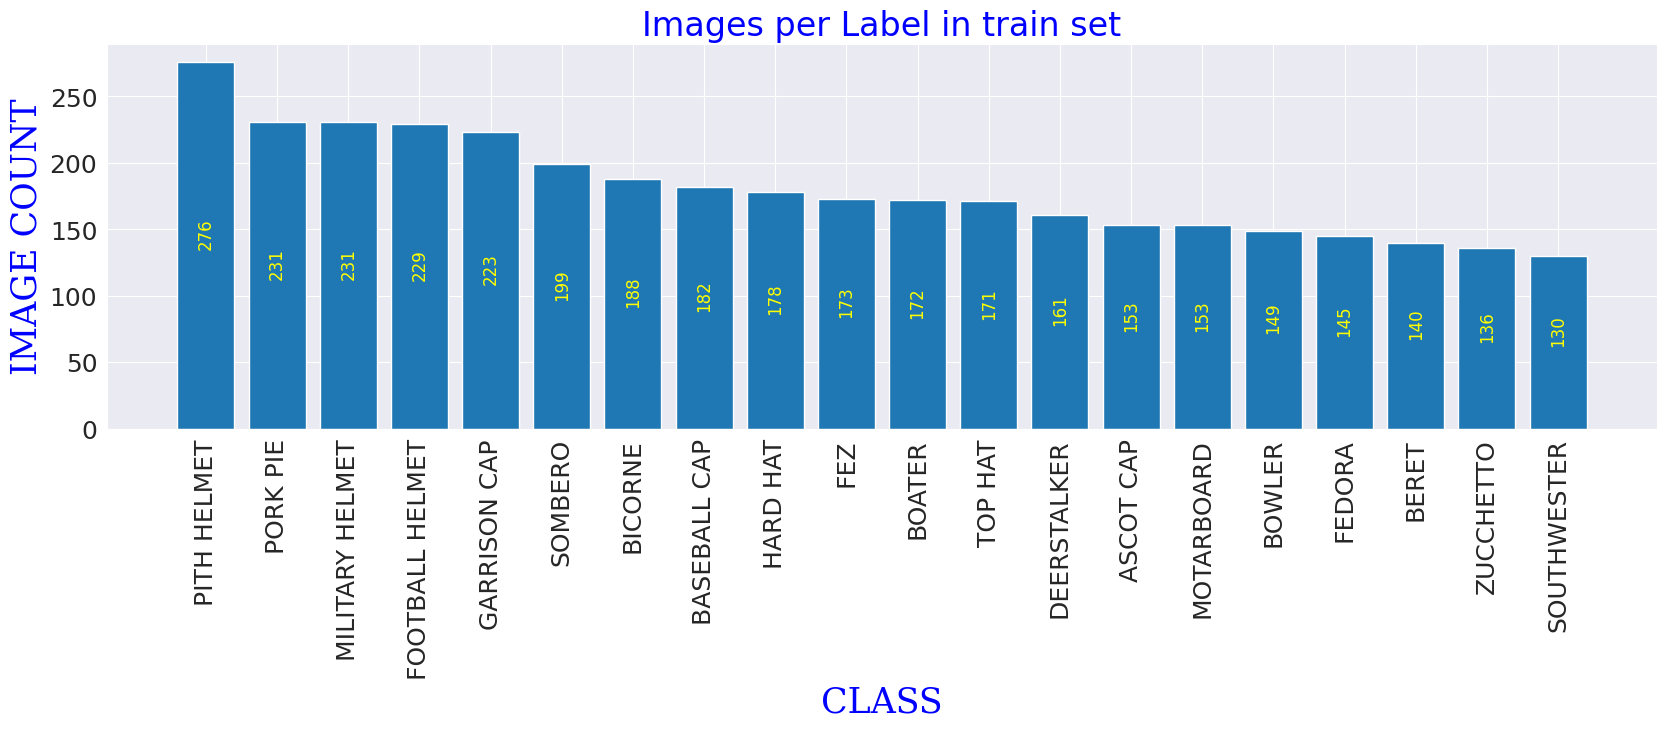

the average height of training images is 224 and average width is 224
  enter the image height to be used to train the model
model will be trained with image shape of  ( 224, 224 )
 enter A  to auto balance the train set or enter or hit enter to leave train set unchanged  
training data set will be used as is 
enter the desired batch size or press enter to use the default batch size of 20  
select a model number from the list below 
Model No      Model Type      Parameters 
    1     MobileNetV3-small      1.0 M   
    2     MobileNetV3-large     3.3 M    
    3      EfficientNetV2B0     6.3 M    
    4      EfficientNetV2B1     7.3 M    
    5      EfficientNetV2B2     9.1 M    
    6      InceptionResNetV2    54.7 M   
4334752/4334752 [==============================] - 0s 0us/step
created MobileNet V3  small model with initial learning rate set to 0.001
enter the number of epochs to run initially. After these epochs complete you can enter H to halt training
or enter an integer for ho

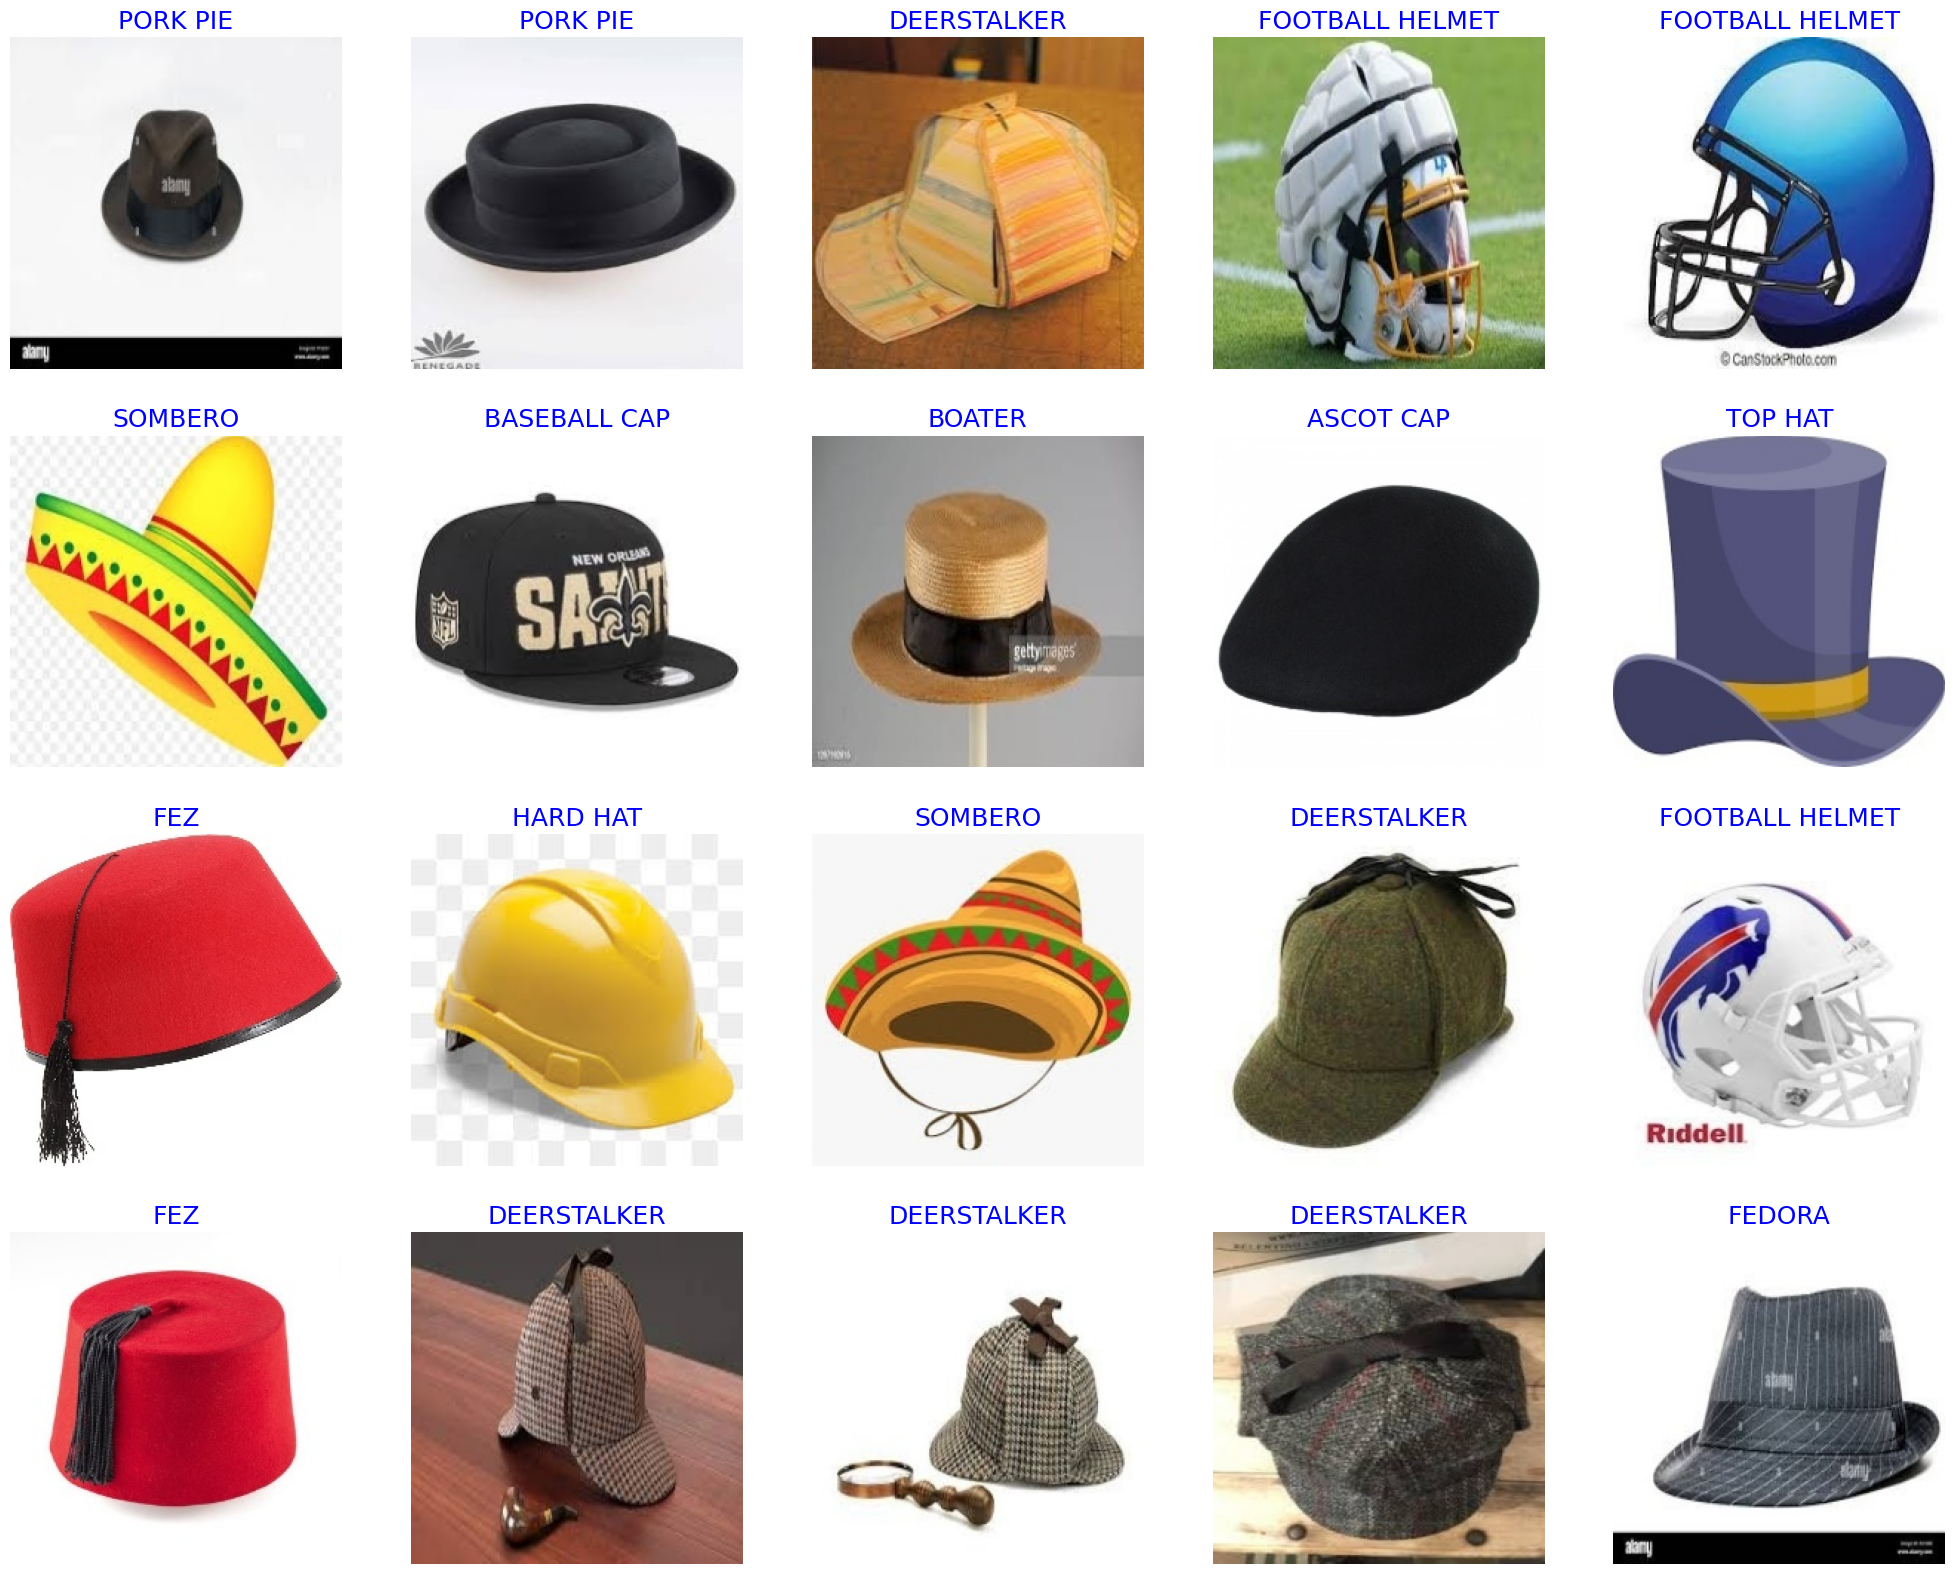

Training will proceed until epoch 10 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
learning rate will be automatically adjusted during training
 Epoch   Train    Train    Valid    Valid     V_Loss %    Learning    Next LR   Duration in  
         Loss   Accuracy   Loss    Accuracy  Improvement    Rate       Rate       Seconds    
   1    7.2258    53.09   6.0912    67.00       0.00      0.001000    0.001000    213.66     
   2    4.9388    83.12   4.5101    77.00       25.96     0.001000    0.001000    195.80     
   3    3.6501    90.75   3.3855    85.00       24.94     0.001000    0.001000    193.70     
   4    2.7052    93.45   2.5227    89.00       25.48     0.001000    0.001000    191.41     
   5    1.9721    96.10   1.9326    89.00       23.39     0.001000    0.001000    192.41     
   6    1.4635    97.18   1.5192    95.00       21.39     0.001000    0.001000    193.57     
   7    1.0934    98.43   1

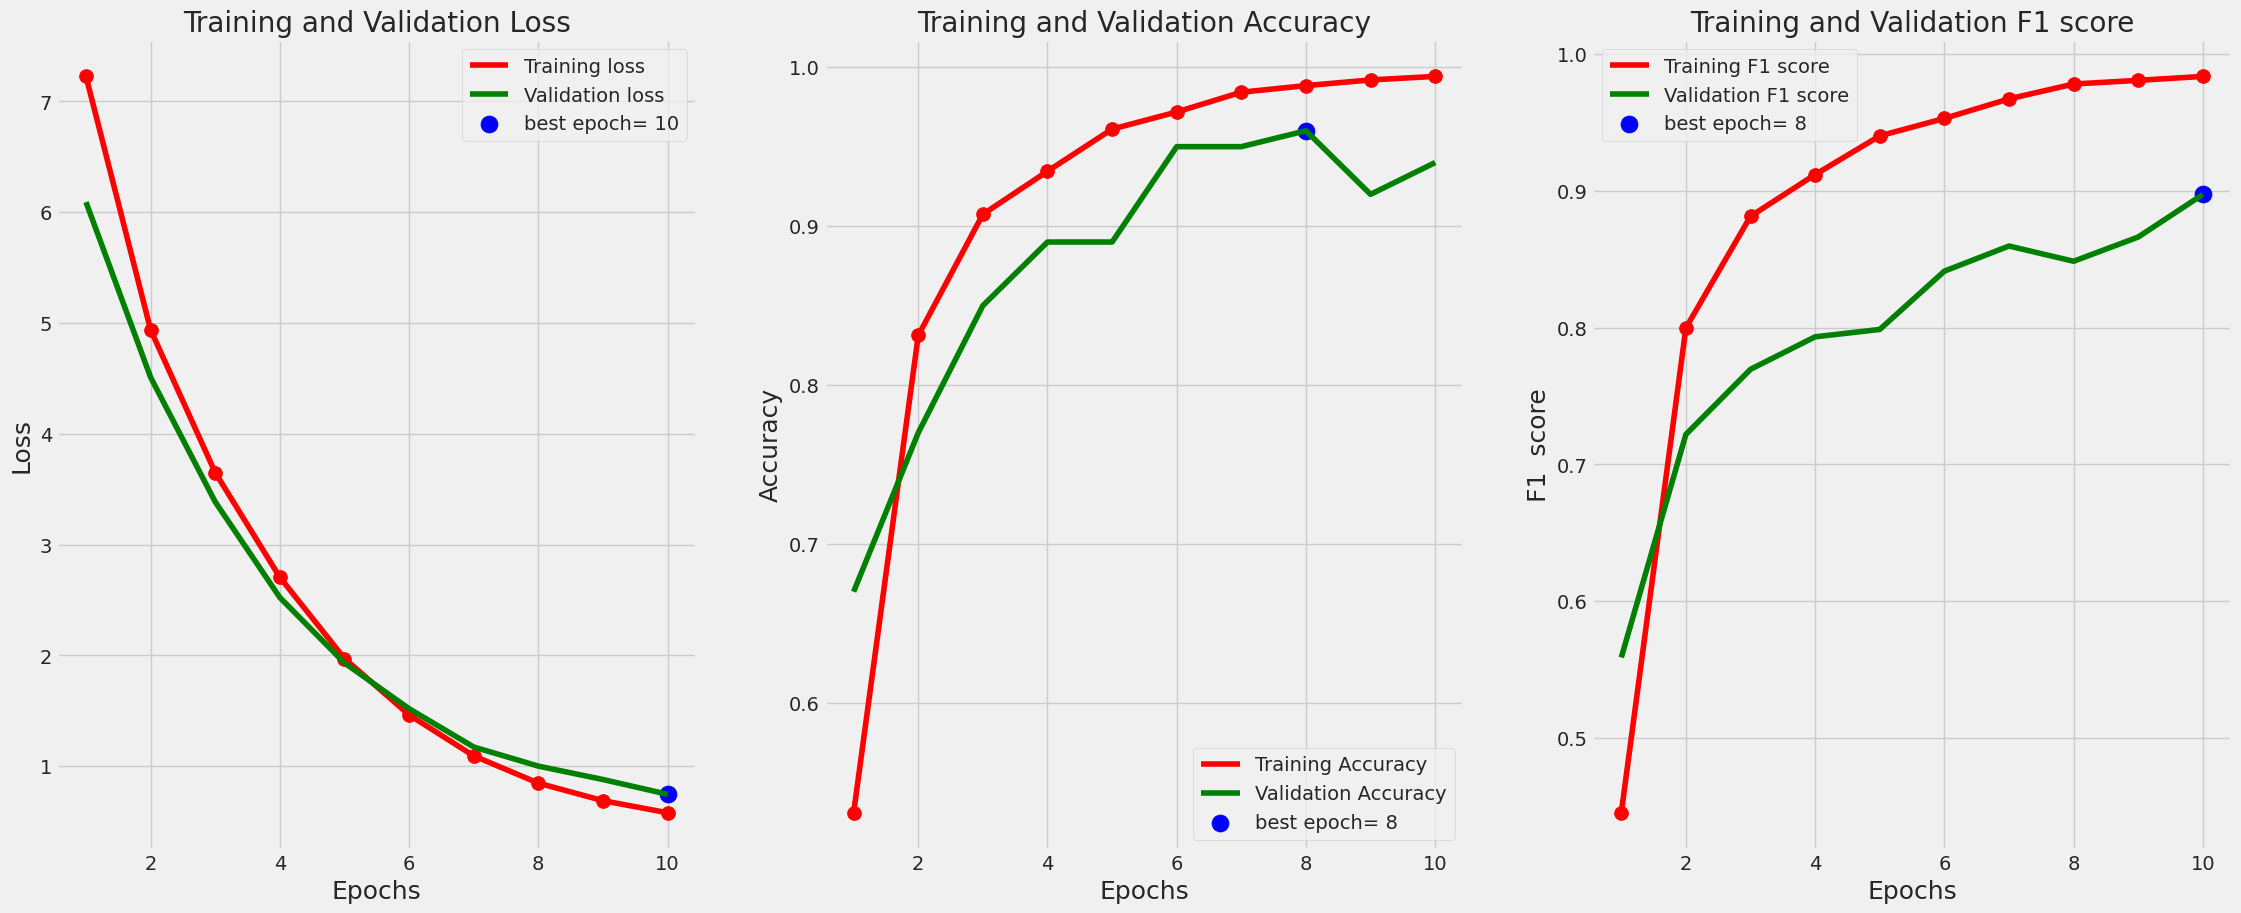

To save the training data to a csv file enter the name for the csv file or press enter to not save the data
2/2 [==============================] - 3s 568ms/step
There were 6 errors in 100 tests for an accuracy of  94.00 and an F1 score of  93.95


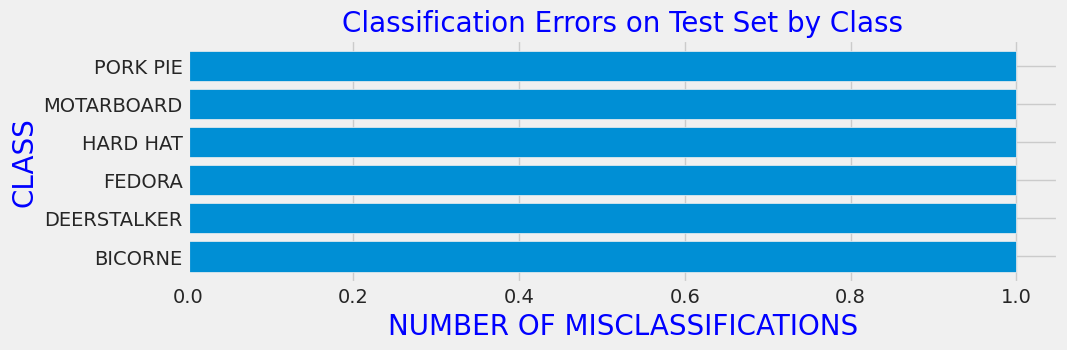

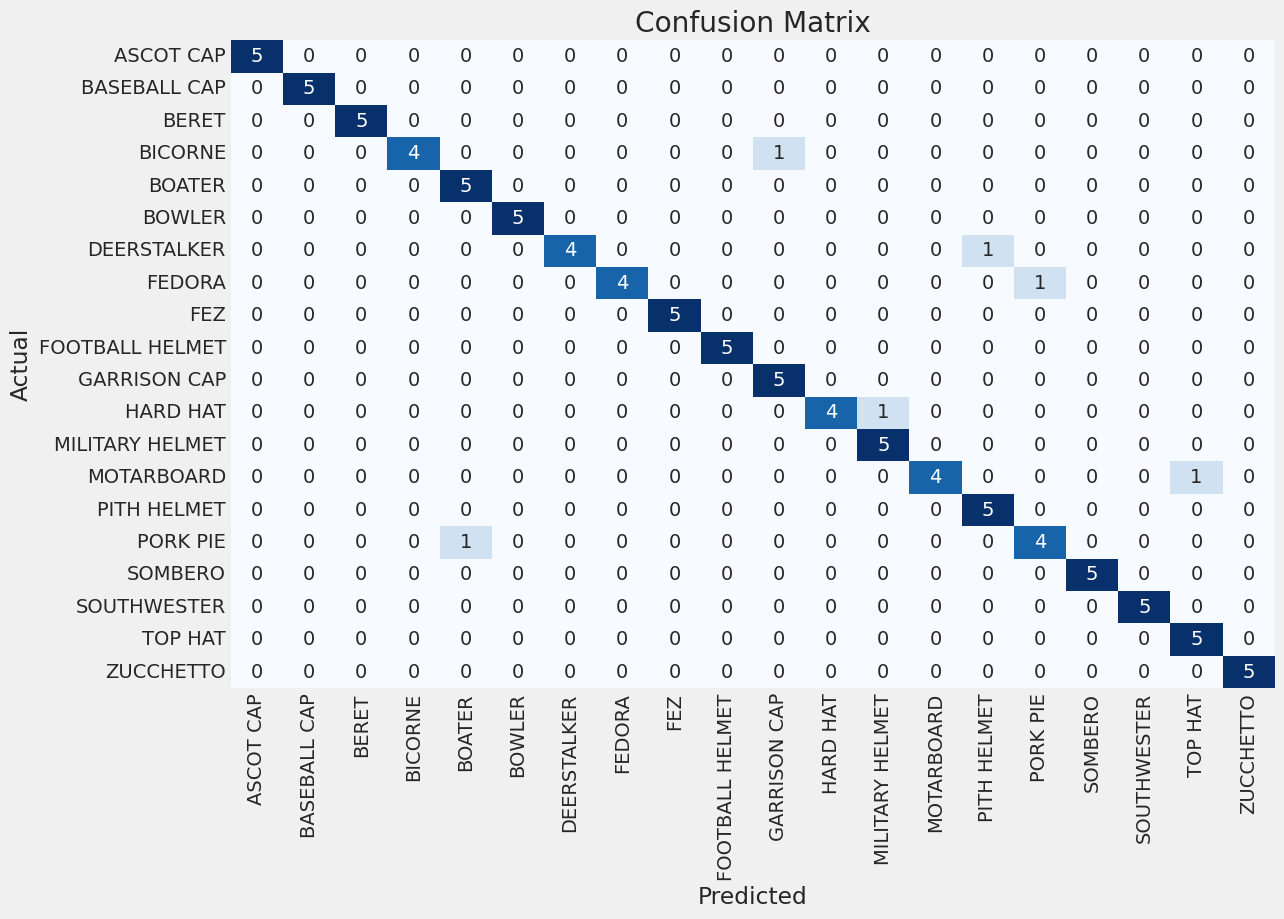

Classification Report:
----------------------
                  precision    recall  f1-score   support

      ASCOT CAP     1.0000    1.0000    1.0000         5
   BASEBALL CAP     1.0000    1.0000    1.0000         5
          BERET     1.0000    1.0000    1.0000         5
        BICORNE     1.0000    0.8000    0.8889         5
         BOATER     0.8333    1.0000    0.9091         5
         BOWLER     1.0000    1.0000    1.0000         5
    DEERSTALKER     1.0000    0.8000    0.8889         5
         FEDORA     1.0000    0.8000    0.8889         5
            FEZ     1.0000    1.0000    1.0000         5
FOOTBALL HELMET     1.0000    1.0000    1.0000         5
   GARRISON CAP     0.8333    1.0000    0.9091         5
       HARD HAT     1.0000    0.8000    0.8889         5
MILITARY HELMET     0.8333    1.0000    0.9091         5
     MOTARBOARD     1.0000    0.8000    0.8889         5
    PITH HELMET     0.8333    1.0000    0.9091         5
       PORK PIE     0.8000    0.8000    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as /content/drive/MyDrive/Colab Notebooks/working_dir/test1-20-(224 X 224)- 93.95.h5
model save nomenclature is directory/subject-number of classes- (img_height, img_width)- F1score.h5
enter R to rerun the classifier or press enter to quit  
 
process commpleted


In [ ]:
working_dir,train_dir, test_dir, valid_dir, model=run(start=False,
          train_dir=TRAINING_DIR, valid_dir= Valid_DIR, test_dir= TESTING_DIR,
          working_dir= WORKING_DIR ) # run the classifier
stop = False
while stop == False:
    msg='enter R to rerun the classifier or press enter to quit  '
    print_in_color(msg)
    ans=input(' ')
    if ans == 'R' or ans == 'r':
        msg='Enter N to specify new data directories or hit Enter to use existing data directory paths '
        print_in_color(msg)
        ans=input(' ')
        if ans == '':
            run(working_dir,train_dir=train_dir, test_dir=test_dir, valid_dir=valid_dir, start=False )
        else:
            run(True)
    else:
        stop = True
        print_in_color ('process commpleted')

<a id="Conclusions"></a>
# <center>Evaluate Model Performance</center>
The EfficentNetB0 model ran for 18 epochs and achieved an F1 score on the test set of 97.98. Average time per epoch was about 24.5 seconds. The MobileNetV3 small model was run for 18 epochs and achieved an F1 score of 06.97. Average time per epoch was about 8.5 seconds.